In [ ]:
pip install noisereduce

In [32]:
from scipy.io.wavfile import read, write
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import noisereduce as nr
import IPython.display as ipd
import pandas as pd

In [33]:
from google.colab import drive
# Ruta de los audios
ruta = '/content/gdrive/MyDrive/Colab Notebooks/Rogan/Álex/audio/'
# Montamos el drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 0.Read WAV file

In [34]:
path = 'data/podcasts_wav/'
file_name = ruta+'jre877.wav'
samplerate, signal = read(file_name)

# Duration in seconds
duration = len(signal)/samplerate
print(f'Read a total of {len(signal)} values, {round(duration/60,2)} minutes of duration.')

Read a total of 176650640 values, 184.01 minutes of duration.


# 1.Basic EDA of our audio signal

In [35]:
# Absolute values from signal
s_abs =  np.abs(signal)

# Basic statistics
print(f'Máx. value: {s_abs.max()}')
print(f'Min value: {s_abs.min()}')
print(f'Average: {round(s_abs.mean(),2)}')
print(f'Median: {int(np.median(s_abs))}')
print(f'Percentage of zeros {round(np.count_nonzero(s_abs==0)/len(s_abs)*100,2)}%')

Máx. value: 32445
Min value: 0
Average: 2103.36
Median: 1003
Percentage of zeros 0.11%


In [ ]:
# Histogram
plt.hist(s_abs, bins = np.arange(0,30000,1000),color='#0504aa',alpha=0.7, rwidth=0.85) 
plt.title("Histogram of signal values") 
plt.show()

In [ ]:
s_log = np.log10(s_abs)

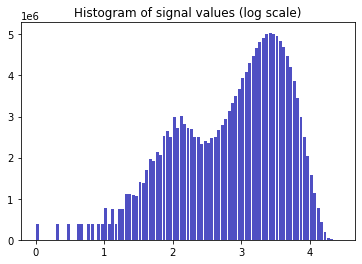

In [37]:
plt.hist(s_log, bins = np.arange(0,4.5,0.05),color='#0504aa',alpha=0.7, rwidth=0.85) 
plt.title("Histogram of signal values (log scale)") 
plt.show()

In [ ]:
# I loos like 2 diffeent distributions are present in our signal
print(f'Inverse of log(2.7) base 10: {10**2.7}')

Inverse of log(2.7) base 10: 501.18723362727246


In [38]:
# 500 will be a threshold value
threshold = 500

# 2.Separate "noise" and "silence"

In [39]:
# Positions where values are lower than threshold
idx_lower = np.where(s_abs<threshold)

# Replace lower values by zero
signal_rep = signal.copy()
np.put(signal_rep, idx_lower, np.zeros(len(signal_rep)))

In [ ]:
print(f'Percentage of zeros in the original signal: {round(np.count_nonzero(signal==0)/len(signal)*100,2)}%')
print(f'Percentage of zeros after replacement: {round(np.count_nonzero(signal_rep==0)/len(signal_rep)*100,2)}%')

Percentage of zeros in the original signal: 0.11%
Percentage of zeros after replacement: 38.92%


In [40]:
# Zero positions
idx_zero = np.where(signal_rep==0)

# Noise
mask = np.ones(signal_rep.size, dtype=bool)
mask[idx_zero] = False
signal_noise = signal[mask]

# Silence
mask_s = np.zeros(signal_rep.size, dtype=bool)
mask_s[idx_zero] = True
signal_silence = signal[mask_s]

Time to listen:

In [ ]:
# 5 minutes from original signal
minutes = 5*60*samplerate
ipd.Audio(signal[:minutes], rate=samplerate) 

In [ ]:
# Signal without silence
ipd.Audio(signal_noise[:minutes], rate=samplerate) 

In [ ]:
# Silence signal
ipd.Audio(signal_silence[:minutes], rate=samplerate)

In [ ]:
# Signal after threshold and noise reduction
signal_clean = nr.reduce_noise(y=signal_rep, sr=samplerate)
ipd.Audio(signal_clean[:minutes], rate=samplerate) 

In [ ]:
# To export audio as wav file
#write("10min_silencio.wav", samplerate, signal_clean[:minutes].astype(np.int16))

# 3.Silence

In [41]:
def consecutive(data, stepsize=1):
  return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [42]:
# Find consecutive sequences of zero positions
idx_consecutive = consecutive(idx_zero[0])

# Length of zero position sets is divided b samplerate thus we get durations
silence_duration = [(len(x)*(1/samplerate)) for x in idx_consecutive]

# Count ocurrences of each duration and create a df
silence_cont = Counter(silence_duration)
df = pd.DataFrame(silence_cont.items(), columns =['Time(s)', 'Count'])

In [43]:
# More information is added
df['From silence set(%)'] = round(df['Count']/len(silence_duration)*100,2)
df['From signal(%)'] = round(df['Count']/len(signal)*100,2)
df_sort_s = df.sort_values(["Count"], ascending=False)
df_sort_s.reset_index(inplace=True,drop=True)
df_sort_s.head(10)

,Time(s),Count,From silence set(%),From signal(%)
0,0.000063,4630673,54.42,2.62
1,0.000125,1498468,17.61,0.85
2,0.000188,705886,8.30,0.40
3,0.000250,414509,4.87,0.23
4,0.000313,265034,3.11,0.15
5,0.000375,180908,2.13,0.10
6,0.000438,127419,1.50,0.07
7,0.000500,96074,1.13,0.05
8,0.000563,73565,0.86,0.04
9,0.000625,59344,0.70,0.03


In [ ]:
# Export results
df_sort_s.to_csv('df_silences.csv')

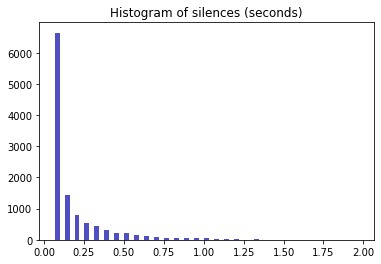

In [44]:
plt.hist(silence_duration, bins = np.arange(0.05,2,0.0625),color='#0504aa',alpha=0.7, rwidth=0.5) 
plt.title("Histogram of silences (seconds)") 
plt.show()

#4.Noise

In [45]:
# Repeat the process for noises
idx_c_noise = consecutive(np.where(signal_rep!=0)[0])
noise_duration = [(len(x)*(1/samplerate)) for x in idx_c_noise]
noise_cont = Counter(noise_duration)
df_noise = pd.DataFrame(noise_cont.items(), columns =['Time(s)', 'Count'])

In [46]:
# More information is added
df_noise['From noise set(%)'] = round(df_noise['Count']/len(noise_duration)*100,2)
df_noise['From signal(%)'] = round(df_noise['Count']/len(signal)*100,2)
df_sort_n = df_noise.sort_values(["Count"], ascending=False)
df_sort_n.reset_index(inplace=True,drop=True)
df_sort_n.head(10)

,Time(s),Count,From noise set(%),From signal(%)
0,0.000063,1624749,19.09,0.92
1,0.000125,1072408,12.60,0.61
2,0.000188,641240,7.54,0.36
3,0.000250,471542,5.54,0.27
4,0.000313,346687,4.07,0.20
5,0.000375,282803,3.32,0.16
6,0.000438,233951,2.75,0.13
7,0.000500,206945,2.43,0.12
8,0.000563,178498,2.10,0.10
9,0.000625,157327,1.85,0.09


In [ ]:
df_sort_n.tail(5)

,Time(s),Count,From noise set(%),From signal(%)
296,0.016000,1,0.0,0.0
297,0.018687,1,0.0,0.0
298,0.015562,1,0.0,0.0
299,0.015750,1,0.0,0.0
300,0.020188,1,0.0,0.0


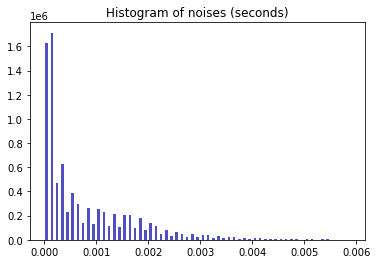

In [ ]:
plt.hist(noise_duration, bins = np.arange(0,0.006,0.0001),color='#0504aa',alpha=0.7, rwidth=0.5) 
plt.title("Histogram of noises (seconds)") 
plt.show()

In [ ]:
df_sort_n.to_csv('df_noises.csv')